In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from scipy.cluster.hierarchy import dendrogram, ward
from sklearn.feature_extraction import text
from sklearn.metrics.pairwise import cosine_similarity
from pylab import rcParams
rcParams['figure.figsize'] = 50, 20
import nltk
from nltk.corpus import stopwords
import re
import time
start=time.time()
nltk.download('stopwords')
%matplotlib inline
import warnings; warnings.simplefilter('ignore')
from statistics import mean 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Elena\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Functions to clean skills data and make a vocabulary for skills vectorization

def text_scrubber(values):
    result = []
    for string in values:
        # Handle NaN values
        if pd.isna(string):
            result.append(np.nan)
        else:
            # Regex as explained above
            temp = re.sub('(\(.*\))', '', string)
            temp = re.sub('&#39;|\x92', '\'', temp)
            temp = re.sub(' &amp; |&amp;|\x95|:|;|&|\.|/| and ', ',', temp)
            result.append(temp)
    return result

def tokenizer(df):
    
    # Custom stop words that come up very often but don't say much about the job title.
    stops = ['manager', 'nice' 'responsibilities', 'used', 'skills', 'duties', 'work', 'worked', 'daily', 'next','magic','world','interview',
             'services', 'job', 'good','using', '.com', 'end', 'prepare', 'prepared', 'lead', 'requirements','#39','see below','yes'] + list(stopwords.words('english'))
    values, ids, resume_ids = [],[],[]
    count = 0
    for idx, row in df.iterrows():
        
        # Split on commas
        array = row['skills']
        array=str(array)
        array=array.lower().split(',')
        for x in array:
            # make sure the value is not empty or all numeric values or in the stop words list
            if x != '' and not x.lstrip().rstrip() in stops and not x.lstrip().rstrip().isdigit():
                # make sure single character results are the letter 'C' (programming language)
                if len(x) > 1 or x == 'C':
                    # drop stuff > 4 gram
                    if len(x.split(' ')) <= 4:
                        # update lists
                        
                        values.append(x.lstrip().rstrip())
                        ids.append(count)
                        count+=1
    
    # New dataframe with updated values.
    result_df = pd.DataFrame()
    
    result_df['skills'] = values
    return result_df

df = pd.read_csv("../../data/dice_com-job_us_sample.csv",encoding='cp850')

df['skills'] = text_scrubber(df['skills'])
test_df = tokenizer(df)

voc = test_df['skills'].unique()
print(voc)

['linux' 'unix' 'network monitoring' ... 'fine arts' 'redgate'
 'nosql-database']


In [4]:
import pandas as pd

# Read the CSV file
df = pd.read_csv("../../data/dice_com-job_us_sample.csv", encoding='cp850')

# Define a function to clean the text in each job description
def clean_text(text):
    cleaned_text = text.replace("&nbsp;", " ").replace("\x92", " ").replace("\x95", " ").replace('&amp;', " ") \
        .replace('*', " ").replace(".", " ").replace("co&#39;s", "").replace("\xae&quot;", "") \
        .replace("&#39;s", "").replace("&quot;", "").replace("?", "").replace("&#39;s", "") \
        .replace("@", "").replace("\x96", "")
    return cleaned_text

# Apply the clean_text function to each element in the 'jobdescription' column
df['jobdescription'] = df['jobdescription'].apply(clean_text)

mine = ['manager', 'amp', 'nbsp', 'responsibilities', 'used', 'skills', 'duties', 'work', 'worked', 'daily','services', 'job', 'using', 'com', 'end', 'prepare', 'prepared', 'lead', 'requirements','summary','Job Role','Position']
vec = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), token_pattern='[a-zA-z]{3,50}', max_df=0.2, min_df=2, max_features=10000, stop_words=list(text.ENGLISH_STOP_WORDS.union(list(mine))), decode_error='ignore', vocabulary=None, binary=False)

df['skills']=df['skills']+df['jobdescription']+df['jobtitle']
description_matrix2 = vec.fit_transform(df['skills'].values.astype('U'))
description_matrix2 = pd.DataFrame(description_matrix2.todense())
description_matrix2.columns = vec.get_feature_names_out()

print(df['jobdescription'])

0        Looking for Selenium engineers   must have sol...
1        The University of Chicago has a rapidly growin...
2        GalaxE SolutionsEvery day, our solutions affec...
3        Java DeveloperFull-time/direct-hireBolingbrook...
4        Midtown based high tech firm has an immediate ...
                               ...                        
21995    ┬áCompany Description┬áWe are searching for a ...
21996    ┬áCONTACT - priyaomegasolutioninc com┬á/ 408-4...
21997    Do you take pride in your work knowing that th...
21998    Company Description┬áWhat We Can Offer YouAs t...
21999    Experience in C/C++ ProgrammingDevelopment exp...
Name: jobdescription, Length: 22000, dtype: object


In [5]:
vec2 = TfidfVectorizer(vocabulary=voc, decode_error='ignore')
df['skills']=df['skills']+df['jobdescription']+df['jobtitle']
skills_matrix2 = vec2.fit_transform(df['skills'].values.astype('U'))
skills_matrix2 = pd.DataFrame(skills_matrix2.todense())
skills_matrix2.columns = vec2.get_feature_names_out()

In [6]:
jobtitle_matrix = pd.concat([skills_matrix2, description_matrix2], axis=1)
jobtitle_matrix

,linux,unix,network monitoring,incident response,systems administration,security accessment,enterprise solutions architecture,business inteligence,reports,reporting,...,york,york city,york new,young,yrs,yrs experience,zero,zone,zones,zulily
0,0.000000,0.139247,0.0,0.0,0.0,0.0,0.0,0.0,0.041223,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.079684,0.091208,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.083495,0.22316,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.064860,0.074240,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.150966,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21995,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.033945,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21996,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21997,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21998,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
# Run PCA to reduce number of features

pca = PCA(n_components=1000, random_state=42)
comps = pca.fit_transform(jobtitle_matrix)

# Put the components into a dataframe

comps = pd.DataFrame(comps)

In [8]:
# Cluster job titles based on components derived from feature matrix

cltr = AgglomerativeClustering(n_clusters=8)
cltr.fit(comps)

# Add new column containing cluster number to sample, comps, and feature matrix dataframes

df['cluster_no'] = cltr.labels_
X = comps
y = df['cluster_no']
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, random_state=42)
lr = LogisticRegression(C=10, penalty='l2', multi_class='multinomial', solver='sag', max_iter=1000)
lr.fit(X_train, y_train)
score1=lr.score(X_test, y_test)
print(score1)

0.8849090909090909


In [9]:
cltr1 = AgglomerativeClustering(n_clusters=10)
cltr1.fit(comps)
df['cluster_no'] = cltr1.labels_
X = comps
y = df['cluster_no']
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, random_state=42)
lr = LogisticRegression(C=10, penalty='l2', multi_class='multinomial', solver='sag', max_iter=1000)
lr.fit(X_train, y_train)
score2=lr.score(X_test, y_test)
print(score2)

0.8807272727272727


In [10]:
cltr2 = AgglomerativeClustering(n_clusters=15)
cltr2.fit(comps)
df['cluster_no'] = cltr2.labels_
X = comps
y = df['cluster_no']
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, random_state=42)
lr = LogisticRegression(C=10, penalty='l2', multi_class='multinomial', solver='sag', max_iter=1000)
lr.fit(X_train, y_train)
score3=lr.score(X_test, y_test)
print(score3)

0.8634545454545455


In [11]:
from sklearn.cluster import KMeans
cltr = KMeans(n_clusters=15)
cltr.fit(comps)
df['cluster_no'] = cltr2.labels_
X = comps
y = df['cluster_no']
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, random_state=42)
lr = LogisticRegression(C=10, penalty='l2', multi_class='multinomial', solver='sag', max_iter=1000)
lr.fit(X_train, y_train)
score=lr.score(X_test, y_test)
print(score)

0.8632727272727273


In [12]:
cltr3 = AgglomerativeClustering(n_clusters=20)
cltr3.fit(comps)
df['cluster_no'] = cltr3.labels_

X = comps
y = df['cluster_no']

X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, random_state=42)
lr = LogisticRegression(C=10, penalty='l2', multi_class='multinomial', solver='sag', max_iter=1000)
lr.fit(X_train, y_train)
score4=lr.score(X_test, y_test)
print(score4)

0.8583636363636363


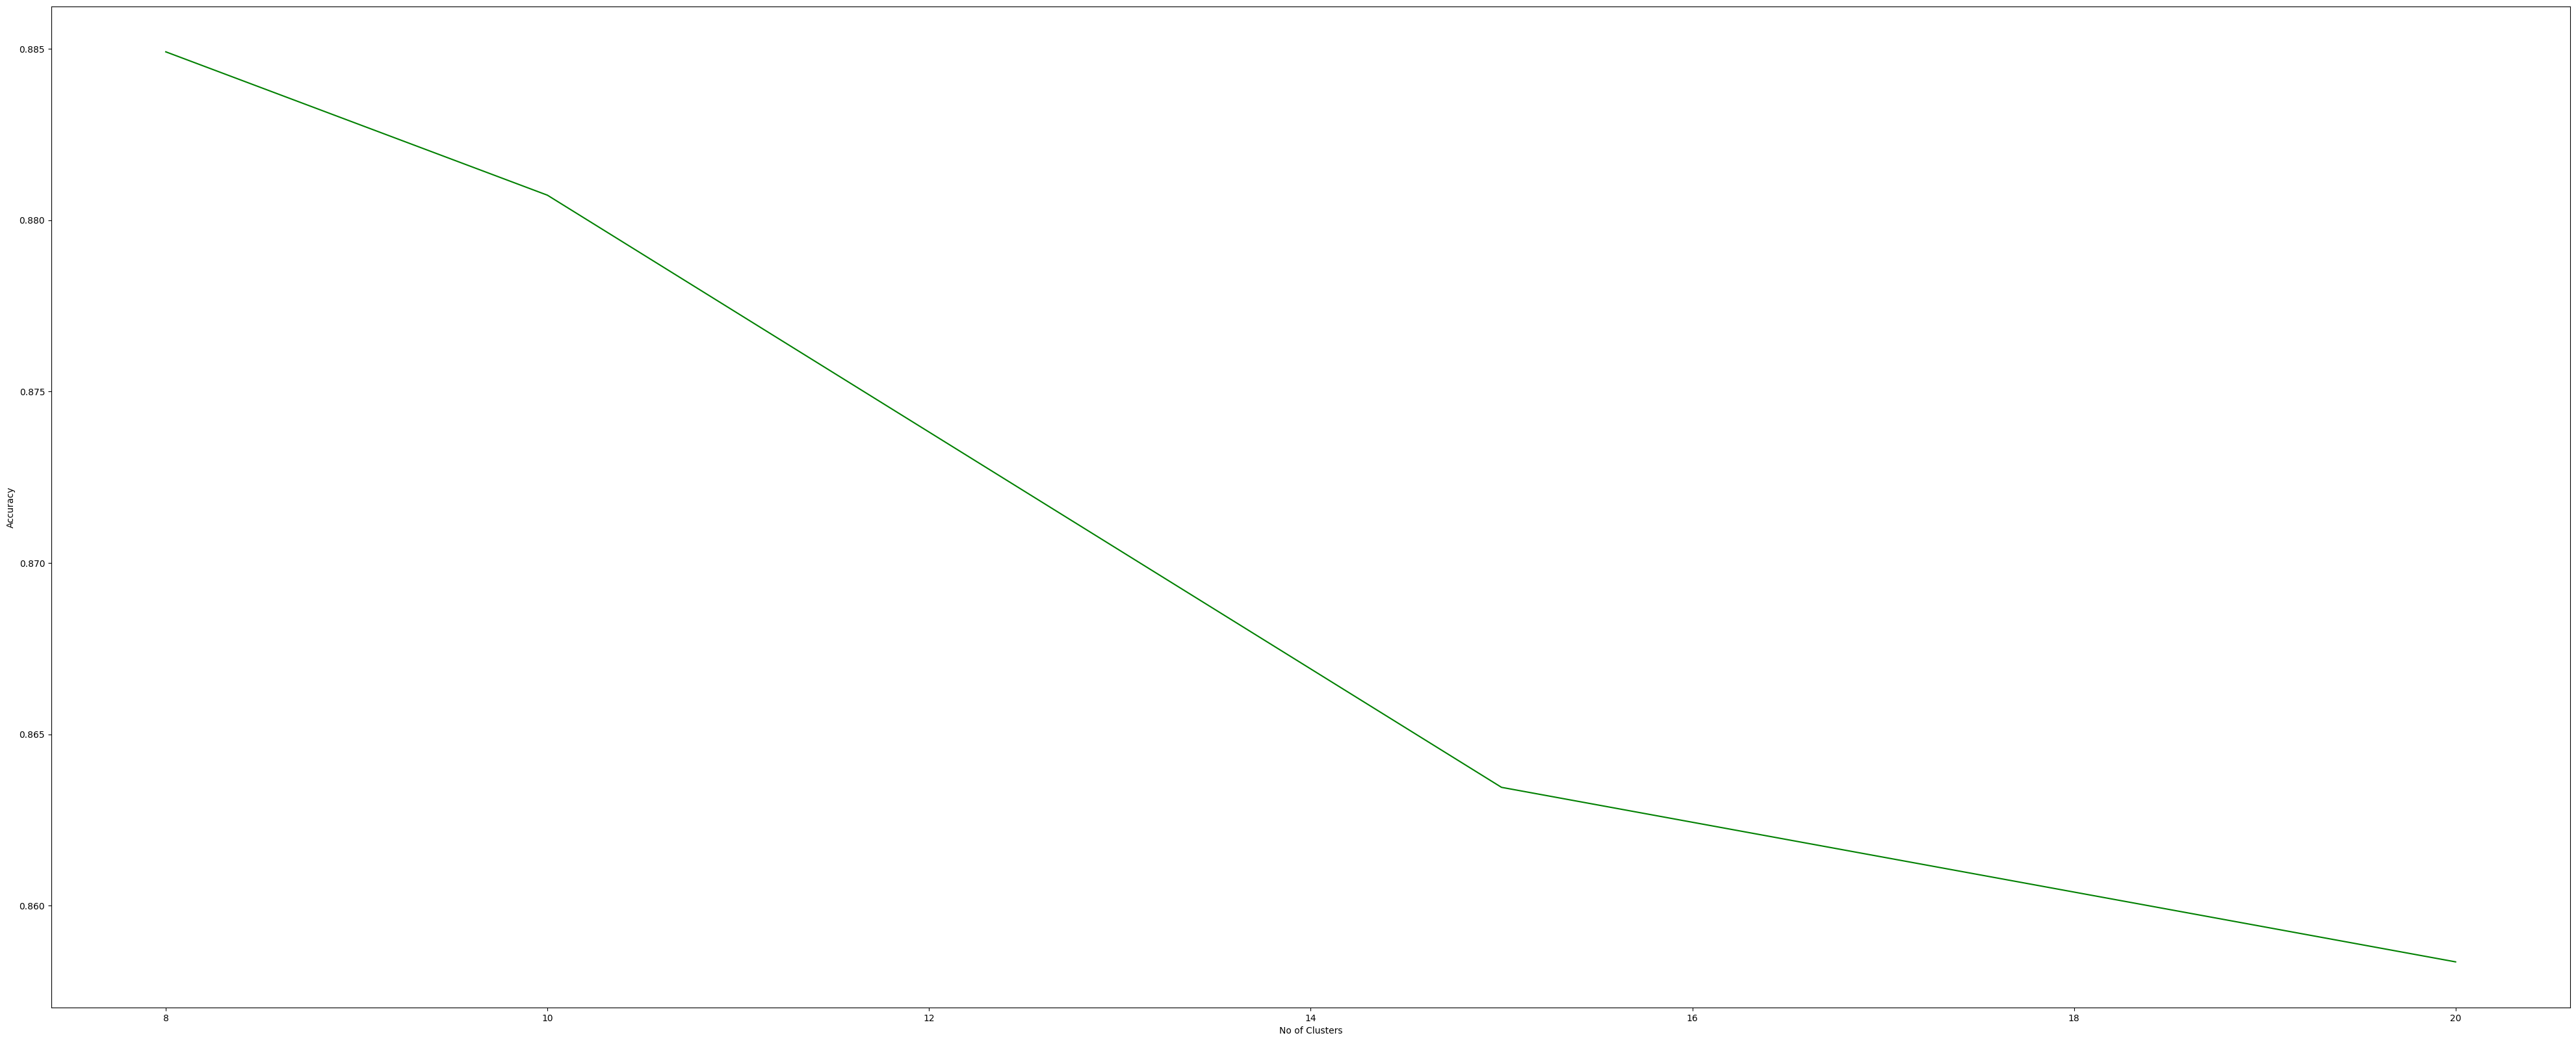

In [13]:
clusters=[8,10,15,20]
accuracy=[score1,score2,score3,score4]

plt.plot(clusters,accuracy, color='g')
plt.xlabel('No of Clusters')
plt.ylabel('Accuracy')
#plt.title('Accuracy')
plt.show()

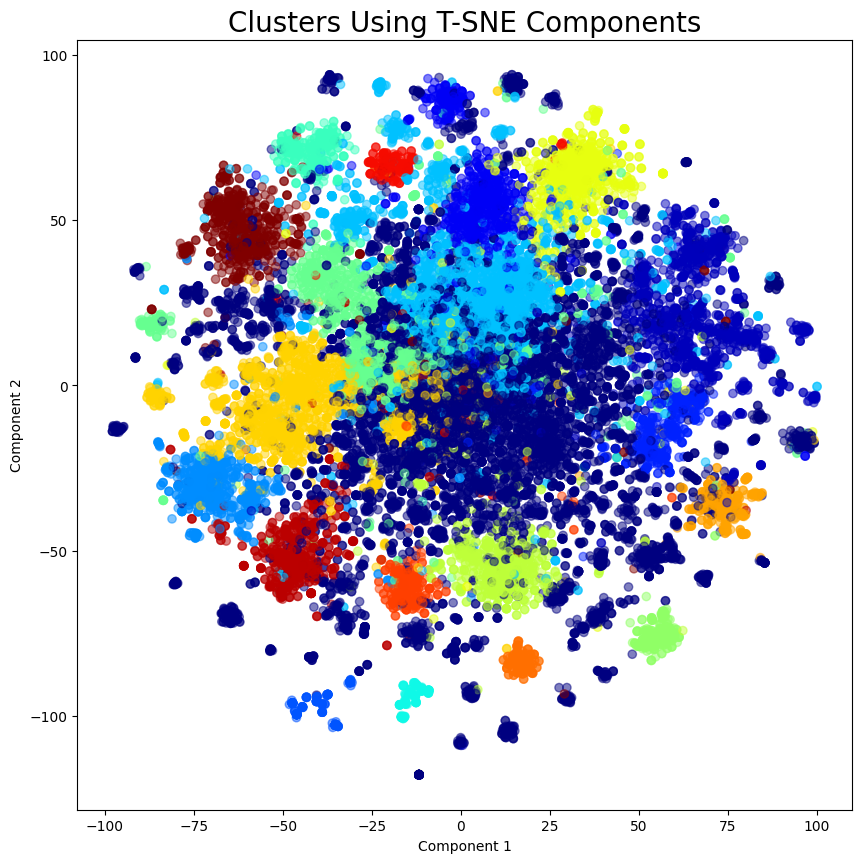

In [14]:
# Look at clusters

from sklearn.manifold import TSNE

tsne = TSNE()
g = pd.DataFrame(tsne.fit_transform(comps), columns=['one', 'two'])


g['cluster_no'] = cltr3.labels_

import matplotlib.cm as cm

plt.figure(figsize=(10,10))
plt.title('Clusters Using T-SNE Components', fontsize=20)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.scatter(g['one'], g['two'], c=g['cluster_no'], cmap=cm.jet, alpha=0.5)

plt.show()

In [15]:
lr.fit(X, y)

LogisticRegression(C=10, max_iter=1000, multi_class='multinomial', solver='sag')

In [16]:
# Assign cluster number to each job title in comps to pull particular cluster out for comparison
comps['cluster_no'] = y.values
comps.set_index('cluster_no', inplace=True)

In [17]:
def give_suggestions(resume_text):
    matches=dict()
    # Vectorize user's skills and job descriptions
    desc = pd.DataFrame(vec.transform([resume_text]).todense())
    desc.columns = vec.get_feature_names_out()
    skillz = pd.DataFrame(vec2.transform([resume_text]).todense())
    skillz.columns = vec2.get_feature_names_out()
    mat = pd.concat([skillz, desc], axis=1)
    # Tranform feature matrix with pca
    user_comps = pd.DataFrame(pca.transform(mat))

    # Predict cluster for user and print cluster number
    cluster = lr.predict(user_comps)[0]
    print ('CLUSTER NUMBER', cluster, '\n\n')

    # Calculate cosine similarity
    cos_sim = pd.DataFrame(cosine_similarity(user_comps,comps[comps.index==cluster]))

    # Get job titles from df to associate cosine similarity scores with jobs
    samp_for_cluster = df[df['cluster_no']==cluster]
    cos_sim = cos_sim.T.set_index(samp_for_cluster['jobtitle'])
    cos_sim.columns = ['score']
    
    # Print the top ten suggested jobs for the user's cluster
    top_cos_sim = cos_sim.sort_values('score', ascending=False)[:10]
    print ('Top ten suggested for your cluster', '\n', top_cos_sim, '\n\n')
    
   # print('Accuracy',)

    # Print the top five suggested jobs for each cluster
    mat = mat.T
    for i in range(8):
        cos_sim = pd.DataFrame(cosine_similarity(user_comps,comps[comps.index==i]))
        samp_for_cluster = df[df['cluster_no']==i]
        cos_sim = cos_sim.T.set_index(samp_for_cluster.index)
        cos_sim.columns = ['score']
        top_5 = cos_sim.sort_values('score', ascending=False)[:5]

        # Merge top_5 with sample2 to get skills and description
        merged_top_5 = top_5.merge(df, how='left', left_index=True, right_index=True)
        print ('---------Top five suggested in cluster', i,  '---------\n', top_5, '\n\n')
        # Vectorize to find skills needed for each job title
       
        for job in merged_top_5.index:
            job_skills = pd.DataFrame(vec2.transform([merged_top_5.loc[job]['jobdescription'] + merged_top_5.loc[job]['skills']]).todense())
            job_skills.columns = vec2.get_feature_names_out()
            job_skills = job_skills.T
            job_skills.columns = ['score']
            job_skills = job_skills[job_skills['score'] != 0].sort_values('score', ascending=False)
            mat.columns = ['score']
            mat = mat[mat['score'] != 0]
            needed_skills = []
            scorey = []
            for i in job_skills.index:
                if i not in mat.index:    
                    needed_skills.append(i)
                    scorey.append(job_skills.loc[i][0])
            top_skills = pd.DataFrame(list(zip(needed_skills, scorey)), columns=['Skills', 'Importance'])
            print('To become a/an', job,',', '\n', 'these are the top ten skills you need:', '\n')
            print(top_skills[:5], '\n')
    return top_cos_sim

In [18]:
#resume_text=input("Enter your skills. These are programming languages, frameworks,platforms or databases that you have experience with")

resume_text = '''jesus.brown3255@gmail.com SUMMARY:I am  a passion for using data to make faster and betterdecisions that leads to improved customer experiences and increased productivity. My combination oftechnical and business experience provides a unique skill-set to be able to work cross-functionally toachieve these results.SKILLSTECHNICAL:Java, Python (Pandas, Scikit-Learn, NumPy, Seaborn), Data Analytics , Big Data (AWS, Hadoop, Spark), Tableau,Advanced Microsoft Excel (Power BI, Macros, etc.) ·Student- DataScience·Oct2016 - Learned the skills to become a data professional including Python (Pandas, Numpy, Seaborn, Scikit-Learn), Advanced SQL,  No-SQL (MongoDB), MachineLearning Modeling , Big Data (AWS, Hadoop, Spark)
'''

In [19]:
cos_sim_result=give_suggestions(resume_text)

CLUSTER NUMBER 1 


Top ten suggested for your cluster 
                                                        score
jobtitle                                                    
Sr DevOps Engineer(Big data / hadoop / hive) fo...  0.538649
Software Engineer                                   0.536550
Scala, Spark, Datawarehouse Big data Expert         0.518647
Senior Engineer - Hadoop                            0.508867
Senior Engineer - Hadoop                            0.508867
Senior Big Data Engineer (Apache, Spark, Hadoop)    0.505307
Hadoop developer                                    0.502868
Big Data Developer                                  0.501122
Spark Developer                                     0.499719
Data Modeler - Big Data                             0.494696 


---------Top five suggested in cluster 0 ---------
           score
12484  0.342985
6977   0.306526
304    0.286552
16336  0.282311
17481  0.281641 


To become a/an 12484 , 
 these are the top ten skills you

In [38]:
import scipy.sparse as sp
from typing import List

def _single_list_similarity(predicted: list, feature_df: pd.DataFrame, u: int) -> float:
    # exception predicted list empty
    if not(predicted):
        raise Exception('Predicted list is empty, index: {0}'.format(u))

    #get features for all recommended items
    feature_df_reset = feature_df.set_index('jobtitle')
    #recs_content = feature_df_reset.concat[predicted]
    recs_content = feature_df.iloc[predicted]
    recs_content = recs_content.dropna()
    recs_content = sp.csr_matrix(recs_content.values)

    #calculate similarity scores for all items in list
    similarity = cosine_similarity(X=recs_content, dense_output=False)

    #get indicies for upper right triangle w/o diagonal
    upper_right = np.triu_indices(similarity.shape[0], k=1)

    #calculate average similarity score of all recommended items in list
    ils_single_user = np.mean(similarity[upper_right])
    return ils_single_user

def intra_list_similarity(predicted: List[list], feature_df: pd.DataFrame) -> float:
    feature_df = feature_df.fillna(0)
    Users = range(len(predicted))
    print(predicted)
    ils = [_single_list_similarity(predicted[u], feature_df, u) for u in Users]
    return np.mean(ils)

In [40]:

top_10_recommendations=cos_sim_result.sort_values('score', ascending=False)[:10]
top_10_list = top_10_recommendations.reset_index().to_records(index=False).tolist()
first_elements = [item[0] for item in top_10_list]
feature_df = df[['jobtitle','jobdescription']]
print(top_10_recommendations)
print(feature_df)
intra_list_similarity(top_10_recommendations, feature_df)


                                                       score
jobtitle                                                    
Sr DevOps Engineer(Big data / hadoop / hive) fo...  0.538649
Software Engineer                                   0.536550
Scala, Spark, Datawarehouse Big data Expert         0.518647
Senior Engineer - Hadoop                            0.508867
Senior Engineer - Hadoop                            0.508867
Senior Big Data Engineer (Apache, Spark, Hadoop)    0.505307
Hadoop developer                                    0.502868
Big Data Developer                                  0.501122
Spark Developer                                     0.499719
Data Modeler - Big Data                             0.494696
                                                jobtitle  \
0                               AUTOMATION TEST ENGINEER   
1                          Information Security Engineer   
2                           Business Solutions Architect   
3      Java Developer (mid l

KeyError: 0